# Setup

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
#@markdown #Pytorch & pain_detection_demo.git

!pip3 -q install torch==1.6 torchvision==0.7
!git clone https://github.com/TaatiTeam/pain_detection_demo.git &> /dev/null

     |████████████████████████████████| 748.8 MB 18 kB/s 
     |████████████████████████████████| 5.9 MB 47.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.6.0 which is incompatible.


## Scripts

### pspi_au_detector.py

In [ ]:
%%writefile /content/pain_detection_demo/pspi_au_detector.py
"""
    source:
        pain_detection_demo/pain_dector.py
    edit:
        * def predict_apin
            * pspi_predictions = predictions[0, -1]
        + def predict_aus
        + def predict_aus_and_pspi
"""

import sys
sys.path.append('..')
sys.path.append('.')
import torch
import face_alignment as FAN
from models.comparative_model import ConvNetOrdinalLateFusion
import numpy as np
import cv2
from skimage.transform import SimilarityTransform, PiecewiseAffineTransform, warp


class PainDetector:
    def __init__(self, num_outputs, checkpoint_path='', fan_checkpoint='', image_size=160):
        """
        :param checkpoint_path: model checkpoint path, cannot be empty
        :param fan_checkpoint: FAN checkpoint path, if empty will download pretrained model
        :param image_size: image size after face detection, must correspond to afar_checkpoint
        """
        self.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        self.ref_frames = []
        self.image_size = image_size
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))  # Histogram normalizer
        # load FAN landmark detector including SFD face detector
        self.FAN = FAN.FaceAlignment(FAN.LandmarksType._2D, flip_input=True, device=self.device,
                                     check_point_path=fan_checkpoint)
        self.face_detector = self.FAN.get_landmarks_from_image
        self.mean_lmks = np.load('standard_face_68.npy')
        self.mean_lmks = self.mean_lmks * 155 / self.mean_lmks.max()
        self.mean_lmks[:, 1] += 15
        # load model model
        self.model = ConvNetOrdinalLateFusion(num_outputs=num_outputs)
        self.model.load_state_dict(torch.load(checkpoint_path, map_location=self.device))
        self.model.eval()

    @staticmethod
    def crop_image(frame, bbox):
        fh, fw = frame.shape[:2]
        bl, bt, br, bb = bbox
        fh, fw, bl, bt, br, bb = int(fh), int(fw), int(bl), int(bt), int(br), int(bb)

        a_slice = frame[max(0, min(bt, fh)):min(fh, max(bb, 0)), max(0, min(bl, fw)):min(fw, max(br, 0)), :]
        new_image = np.zeros((bb - bt, br - bl, 3), dtype=np.float32)
        new_image[max(0, min(bt, fh)) - bt:min(fh, max(bb, 0)) - bt, max(0, min(bl, fw)) - bl:min(fw, max(br, 0)) - bl,
                  :] = a_slice

        h, w = new_image.shape[:2]
        m = max(h, w)
        square_image = np.zeros((m, m, 3), dtype=np.float32)
        square_image[(m - h) // 2:h + (m - h) // 2, (m - w) // 2:w + (m - w) // 2, :] = new_image
        return square_image

    @staticmethod
    def similarity_transform(image, landmarks):
        # anchor coordinate are based on the 240x320 resolution and need to be scaled accordingly for different size images.
        anchor_scale = 320 / image.shape[1]
        anchor = np.array([[110, 71], [210, 71], [160, 170]], np.float32) / anchor_scale
        idx = [36, 45, 57]
        tform = SimilarityTransform()
        tform.estimate(landmarks[idx, :], anchor)
        sim_mat = tform.params[:2, :]
        dst = cv2.warpAffine(image, sim_mat, (image.shape[1], image.shape[0]))
        dst_lmks = np.matmul(np.concatenate((landmarks, np.ones((landmarks.shape[0], 1))), 1), sim_mat.T)[:, :2]
        return dst, dst_lmks

    @staticmethod
    def warp_lmks(tform, coords):
        out = np.empty_like(coords, np.double)
        # determine triangle index for each coordinate
        simplex = tform._inverse_tesselation.find_simplex(coords, tol=None)
        if (simplex == -1).any():  # simplex==-1 when point falls out of convex hull
            pass  # don;t know what to do yet
        for index in range(len(tform._inverse_tesselation.vertices)):
            # affine transform for triangle
            affine = tform.inverse_affines[index]
            # all coordinates within triangle
            index_mask = simplex == index
            out[index_mask, :] = affine(coords[index_mask, :])
        return out

    @staticmethod
    def piecewise_affine_transform(image, source_lmks, target_lmks):
        anchor = list(range(31)) + [36, 39, 42, 45, 48, 51, 54, 57]
        tgt_lmks = target_lmks[anchor, :]
        dst_lmks = source_lmks[anchor, :]
        tform = PiecewiseAffineTransform()
        tform.estimate(tgt_lmks, dst_lmks)
        dst = warp(image, tform, output_shape=image.shape[:2]).astype(np.float32)
        return dst

    def add_references(self, image_list):
        """
        Use this to add a reference image for the model to compare target frames against.
        Reference images are assumed to have a PSPI score of zero
        :param image_list:  A list of numpy images of shape (H, W, 3)
        :return: None
        """
        for image in image_list:
            self.ref_frames.append(self.prep_image(image))

    def verify_refenerece_image(self, image, scale_to=320, color=(0, 255, 0), size=4, offset=(0, 0)):
        """
        It run the input image through the pre-processing steps (most importantly face and landmark detection).
        It then draws the landmarks on the image so it can be visually inspected.
        :param image: An image with a frontal face in it
        :return: The input image with facial landmarks overlaid
        """
        # Scaling the image to reduce its width to `scale_to`.
        # This makes sure that the run time is consistent by making sure the input image size is fixed.
        image = np.flip(image, axis=2)
        image = cv2.resize(image, (scale_to, int(image.shape[0] * scale_to/image.shape[1])), interpolation=cv2.INTER_AREA)
        landmarks = self.face_detector(image)
        num_faces = 0 if landmarks is None else len(landmarks)
        cv2.putText(image, '{} face/s detected'.format(num_faces), (7, 16), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (70, 70, 70))
        cv2.putText(image, '{} face/s detected'.format(num_faces), (6, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color)
        for lmk in landmarks:
            for lm in lmk.astype(np.int):
                cv2.drawMarker(image, (lm[0] + offset[0], lm[1] + offset[1]), color, cv2.MARKER_CROSS, size)

        return image

    def prep_image(self, image, scale_to=320):
        """
        Runs images through the preprocessing steps
        :param image: A numpy image of shape (H, W, 3). The image should only have one face in it
        :return: Returns an image ready to be passed to the model
        """
        # Scaling the image to reduce its width to `scale_to`.
        # This makes sure that the run time is consistent by making sure the input image size is fixed.
        image = cv2.resize(image, (scale_to, int(image.shape[0] * scale_to/image.shape[1])), interpolation=cv2.INTER_AREA)
        # We need to `mean_lmks`, because `self.mean_lmks` is based on 240x320 resolution images
        mean_lmks = self.mean_lmks * scale_to / 320
        landmarks = self.face_detector(image)
        if len(landmarks) > 1:
            ValueError('Reference image had more than one face. I should only have one')
        else:
            landmark = landmarks[0]
        image_face, lmks = self.similarity_transform(image, landmark)
        image_face = self.piecewise_affine_transform(image_face, lmks, mean_lmks)
        landmark = mean_lmks.round().astype(np.int)
        b_box = [landmark[:, 0].min(), landmark[:, 1].min(), landmark[:, 0].max(), landmark[:, 1].max()]
        image_face = self.crop_image(image_face, b_box)
        image_face = cv2.resize(image_face, (self.image_size, self.image_size))
        if len(image_face.shape) > 2 and image_face.shape[2] == 3:
            image_face = np.matmul(image_face, np.array([[0.114], [0.587], [0.299]]))
        image_face = self.clahe.apply((image_face * 255).astype(np.uint8))
        image_face = image_face.reshape(1, 1, self.image_size, self.image_size).astype(np.float32)
        return torch.from_numpy(image_face) / 255

    def predict_pain(self, image):
        """
        Main predictor function, takes an image as input and returns a float number as pain prediction
        :param image: RGB input image, size (Height x Width x Channel)
        :return: a float32 number, the estimated pain score
        """
        pain_scores = []
        target_frame = self.prep_image(image)
        with torch.no_grad():
            # Gets a prediction for the target frame using every reference frame.
            for ref_frame in self.ref_frames:
                frames = torch.cat([target_frame, ref_frame], dim=1)
                predictions = self.model(frames).detach().cpu().numpy()
                # pspi_predictions = predictions[0, -3:]  # The last 3 outputs predict PSPI for Dementia, Healthy, and UNBC.
                pspi_predictions = predictions[0, -1]  # UNBC only
                pspi_predictions = np.clip(pspi_predictions, 0, None)  # Because PSPI >= 0
                pain_scores.append(pspi_predictions)
        # computes the mean of all the predictions.
        mean_score = np.array(pain_scores).mean()
        return mean_score

    def predict_aus(self, image):
        aus = []
        target_frame = self.prep_image(image)
        with torch.no_grad():
            # Gets a prediction for the target frame using every reference frame.
            for ref_frame in self.ref_frames:
                frames = torch.cat([target_frame, ref_frame], dim=1)
                predictions = self.model(frames).detach().cpu().numpy()
                # au_predictions = predictions[0, :-3]
                au_predictions = predictions[0, :-1]
                au_predictions = np.clip(au_predictions, 0, None)
                aus.append(au_predictions)
        mean_aus = np.array(aus).mean(axis=0)
        return mean_aus

    def predict_aus_and_pspi(self, image):
        aus = []
        pain_scores = []

        target_frame = self.prep_image(image)
        with torch.no_grad():
            # Gets a prediction for the target frame using every reference frame.
            for ref_frame in self.ref_frames:
                frames = torch.cat([target_frame, ref_frame], dim=1)
                predictions = self.model(frames).detach().cpu().numpy()

                au_predictions = predictions[0, :-1]
                pspi_predictions = predictions[0, -1]  # UNBC only

                au_predictions = np.clip(au_predictions, 0, None)
                pspi_predictions = np.clip(pspi_predictions, 0, None)  # Because PSPI >= 0

                aus.append(au_predictions)
                pain_scores.append(pspi_predictions)

        mean_aus = np.array(aus).mean(axis=0)
        mean_score = np.array(pain_scores).mean()
        return mean_aus, mean_score

Writing /content/pain_detection_demo/pspi_au_detector.py


### test_pspi_au.py

In [ ]:
%%writefile /content/pain_detection_demo/test_pspi_au.py
"""
    source:
        pain_detection_demo/test.py
    edit:
        * pain_detector.py -> pspi_au_detector.py
"""

# from pain_detector import PainDetector
from pspi_au_detector import PainDetector
import cv2
import time
import argparse
import os
import glob
import pandas as pd


parser = argparse.ArgumentParser(description='Trains!')
parser.add_argument('-unbc_only', action='store_true', default=False,
                    help='Load the checkpoint that was only trained on UNBC. Otherwise loaded the checkpoint that was train on Both UNBC and UofR datasets')
parser.add_argument('-test_framerate', action='store_true', default=False,
                    help='Runs frame rate test as well')
parser.add_argument('-v', action='store_true', default=False, help='verbosity')
parser.add_argument('-test_data', type=str, required=True, help='Path to test images directory')
parser.add_argument('--s', type=str, help='Path to result csv')

args = parser.parse_args()

if args.unbc_only:
    pain_detector = PainDetector(image_size=160,
                                 checkpoint_path='checkpoints/59448122/59448122_3/model_epoch13.pt',
                                 num_outputs=7)
else:
    pain_detector = PainDetector(image_size=160,
                                 checkpoint_path='checkpoints/50342566/50343918_3/model_epoch4.pt',
                                 num_outputs=40)

print('Device: ', pain_detector.device)

test_data = args.test_data
ref_frames_dir = os.path.join(test_data, 'reference_frames')
target_frames_dir = os.path.join(test_data, 'target_frames')
exts = ['*.jpg', '*.jpeg', '*.png']

ref_frames = []
for e in exts:
    ref_frames.extend(glob.glob(os.path.join(ref_frames_dir, e)))
ref_frames = sorted(ref_frames)

ref_frame_1 = cv2.imread(ref_frames[0])
ref_frame_2 = cv2.imread(ref_frames[1])
ref_frame_3 = cv2.imread(ref_frames[2])

pain_detector.add_references([ref_frame_1, ref_frame_2, ref_frame_3])

target_frames = []
for e in exts:
    target_frames.extend(glob.glob(os.path.join(target_frames_dir, e)))
target_frames = sorted(target_frames)

au_estimate_all = []
au_to_pspi_all = []
pain_estimate_all = []

for t in target_frames:
    target_frame = cv2.imread(t)
    target_frame_name = os.path.basename(t)
    au_estimate, pain_estimate = pain_detector.predict_aus_and_pspi(target_frame)
    
    au_4, au_6, au_7, au_9, au_10, au_43 = au_estimate  # TODO: check order
    au_43_bin = 0 if round(au_43)==0 else 1
    au_to_pspi = au_4 + max(au_6, au_7) + max(au_9, au_10) + au_43_bin

    au_estimate_all.append(au_estimate)
    pain_estimate_all.append(pain_estimate)
    au_to_pspi_all.append(au_to_pspi)

    if args.v:
        print(f'[{target_frame_name}] pspi: {pain_estimate:.2f}')
        print(
            f'[{target_frame_name}] AU04: {au_4:.2f} AU06: {au_6:.2f} AU07: {au_7:.2f}',
            f'AU09: {au_9:.2f} AU10: {au_10:.2f} AU43: {au_43:.2f} => pspi {au_to_pspi:.2f}')

if args.s is not None:
    df = pd.DataFrame(au_estimate_all, columns=['AU4', 'AU6', 'AU7', 'AU9', 'AU10', 'AU43'])
    df['PSPI_from_AU'] = au_to_pspi_all
    df['PSPI'] = pain_estimate_all
    df.insert(0, 'frame', [os.path.basename(t) for t in target_frames])
    df.to_csv(args.s, header=True)


if args.test_framerate:
    num_of_frames = 30
    print('Testing frame rate with {} frames'.format(num_of_frames))
    start_time = time.time()
    for _ in range(num_of_frames):
        pain_detector.predict_pain(target_frame)
    print('FPS: {}'.format(num_of_frames / (time.time() - start_time)))

Writing /content/pain_detection_demo/test_pspi_au.py


## Utils

In [ ]:
import cv2
import numpy as np
import csv

def frames_to_video(frames_dir, output_path):
    filenames = [f for f in os.listdir(frames_dir) if 
                 f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    filenames = sorted(filenames)
    
    first_frame = cv2.imread(os.path.join(frames_dir, filenames[0]))
    h, w, _ = first_frame.shape

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    video = cv2.VideoWriter(output_path, fourcc, 30, (w,h))
    
    for filename in filenames:
        video.write(cv2.imread(os.path.join(frames_dir, filename)))

    video.release()
    cv2.destroyAllWindows()

    print(f'Successfully generated! {output_path}')


def pspi_text_to_csv(pspi_true_dir, output_csv):
    filenames = [f for f in os.listdir(pspi_true_dir) if f.lower().endswith('.txt')]
    filenames = sorted(filenames)

    frame_num = np.arange(len(filenames))
    pspi = []
    for filename in filenames:
        with open(os.path.join(pspi_true_dir, filename), 'r') as txt_file:
            p = txt_file.readline()
            pspi.append(p)

    rows = zip(frame_num, pspi)
    with open(output_csv, 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(('frame_num', 'gt_pspi'))
        for row in rows:
            writer.writerow(row)

    print(f'Ground Truth PSPI csv file saved to {output_csv}')


def aus_to_pspi(aus):
    """ Compute PSPI from AU intensities
        PSPI = AU_4 + max(AU_6,AU_7) + max(AU_9,AU_10) + AU_43
        
        Input:
            aus: a list of AU intensities
                * use AU_45 (blink) instead of AU_43 (eyes_closed)
                * list values in increasing order of the unit number
                  0:4, 1:6, 2:7, 3:9, 4:10, 5:45
        Output:
            PSPI score in float
    """
    term_1 = aus[0]
    term_2 = max(aus[1], aus[2])
    term_3 = max(aus[3], aus[4])
    term_4 = 0 if round(aus[5])==0 else 1

    pspi = term_1 + term_2 + term_3 + term_4

    return round(pspi, 2)


def plot_pspi(pspi_true_csv, pspi_pred_csv, save_path, display=False):
    true_df = pd.read_csv(pspi_true_csv)
    pred_df = pd.read_csv(pspi_pred_csv)
    x = true_df['frame_num']
    y_true = true_df['gt_pspi']
    y_pred = pred_df['PSPI_from_AU']

    plt.plot(x, y_true, label='Ground Truth')
    plt.plot(x, y_pred, label='PSPI from AU')
    plt.ylim((0,15))
    plt.yticks(np.arange(16))
    plt.xlabel('Frames')
    plt.ylabel('PSPI')

    plt.legend(loc='upper right')

    plt.savefig(save_path)

    if display:
        plt.show()
    else:
        plt.close()

# Data

In [ ]:
#@markdown #Load *UNBC-McMaster shoulder pain* Dataset

!mkdir -p './dataset/UNBCMcMaster/'
!cp '/gdrive/MyDrive/datasets/UNBC-McMaster/Frame_Labels.zip' './dataset/UNBCMcMaster/'
!cp '/gdrive/MyDrive/datasets/UNBC-McMaster/Images.zip' './dataset/UNBCMcMaster/'
!unzip -q './dataset/UNBCMcMaster/Frame_Labels.zip' -d './dataset/UNBCMcMaster/'
!unzip -q './dataset/UNBCMcMaster/Images.zip' -d './dataset/UNBCMcMaster/'

In [ ]:
import os

dataset_dir = '/content/dataset/UNBCMcMaster/' #@param {type: 'string'}
patient_name = '064-ak064' #@param {type: 'string'}
sequence_name = 'ak064t1aaaff' #@param {type: 'string'}

test_name = 'test-64-1' #@param {type: 'string'}

img_dir = os.path.join(dataset_dir, 'Images', patient_name, sequence_name)
gt_pspi_dir = os.path.join(dataset_dir, 'Frame_Labels/PSPI', patient_name, sequence_name)

test_data_dir = f'/content/pain_detection_demo/{test_name}'
test_data_ref = f'{test_data_dir}/reference_frames'
test_data_target = f'/content/pain_detection_demo/{test_name}/target_frames'

!mkdir -p $test_data_ref
!mkdir -p $test_data_target

ref_frame_1 = f'{img_dir}/{sequence_name}001.png'
ref_frame_2 = f'{img_dir}/{sequence_name}002.png'
ref_frame_3 = f'{img_dir}/{sequence_name}003.png'

result_data_dir = f'/content/{test_name}_results'
!mkdir -p $result_data_dir

result_csv = f'{result_data_dir}/{test_name}.csv'
gt_pspi_csv = f'/content/dataset/gt-pspi_{test_name}.csv'
patient_vid = f'{result_data_dir}/{test_name}.mp4'
au_vid = f'{result_data_dir}/{test_name}_au.mp4'
pspi_vid = f'{result_data_dir}/{test_name}_pspi.mp4'
output_vid = f'{result_data_dir}/{test_name}_out.mp4'
pspi_png = f'{result_data_dir}/{test_name}_pspi.png'

print(f'         img_dir: {img_dir}')
print(f'     gt_pspi_dir: {gt_pspi_dir}')
print(f'   test_data_dir: {test_data_dir}')
print(f'   test_data_ref: {test_data_ref}')
print(f'test_data_target: {test_data_target}\n')

print(f'     ref_frame_1: {ref_frame_1}')
print(f'     ref_frame_2: {ref_frame_2}')
print(f'     ref_frame_3: {ref_frame_3}\n')

print(f' result_data_dir: {result_data_dir}')
print(f'      result_csv: {result_csv}')
print(f'     gt_pspi_csv: {gt_pspi_csv}')
print(f'     patient_vid: {patient_vid}')
print(f'          au_vid: {au_vid}')
print(f'        pspi_vid: {pspi_vid}')
print(f'      output_vid: {output_vid}')


         img_dir: /content/dataset/UNBCMcMaster/Images/064-ak064/ak064t1aaaff
     gt_pspi_dir: /content/dataset/UNBCMcMaster/Frame_Labels/PSPI/064-ak064/ak064t1aaaff
   test_data_dir: /content/pain_detection_demo/test-64-1
   test_data_ref: /content/pain_detection_demo/test-64-1/reference_frames
test_data_target: /content/pain_detection_demo/test-64-1/target_frames

     ref_frame_1: /content/dataset/UNBCMcMaster/Images/064-ak064/ak064t1aaaff/ak064t1aaaff001.png
     ref_frame_2: /content/dataset/UNBCMcMaster/Images/064-ak064/ak064t1aaaff/ak064t1aaaff002.png
     ref_frame_3: /content/dataset/UNBCMcMaster/Images/064-ak064/ak064t1aaaff/ak064t1aaaff003.png

 result_data_dir: /content/test-64-1_results
      result_csv: /content/test-64-1_results/test-64-1.csv
     gt_pspi_csv: /content/dataset/gt-pspi_test-64-1.csv
     patient_vid: /content/test-64-1_results/test-64-1.mp4
          au_vid: /content/test-64-1_results/test-64-1_au.mp4
        pspi_vid: /content/test-64-1_results/test-64-

In [ ]:
# reference frames
!cp $ref_frame_1 $test_data_ref
!cp $ref_frame_2 $test_data_ref
!cp $ref_frame_3 $test_data_ref

# target frames
!cp -r $img_dir/* $test_data_target

# Test

## run pain detection

In [ ]:
%cd /content/pain_detection_demo
!python test_pspi_au.py --s $result_csv -unbc_only -test_data $test_data_dir

/content/pain_detection_demo
  is not a file. Loading model from:  /content/pain_detection_demo/pretrained
Device:  cuda:0


## frames to video

In [ ]:
frames_to_video(test_data_target, patient_vid)

Successfully generated! /content/test-64-1_results/test-64-1.mp4


## AU predictions to video

In [ ]:
from IPython.display import HTML
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import pandas as pd

fields = ['AU4', 'AU6', 'AU7', 'AU9', 'AU10', 'AU43']

df = pd.read_csv(result_csv, usecols=fields)

fig, ax = plt.subplots()
ax.set_ylim((0,5))
ax.set_xlabel('AU')
ax.set_ylabel('Intensity')

bar_04 = df['AU4'][0]
bar_06 = df['AU6'][0]
bar_07 = df['AU7'][0]
bar_09 = df['AU9'][0]
bar_10 = df['AU10'][0]
bar_43 = df['AU43'][0]
    
bars = plt.bar(['4', '6', '7', '9', '10', '43'],
               [bar_04, bar_06, bar_07, bar_09, bar_10, bar_43], color='orange')

def animate(i):
    h_04 = df['AU4'][i]
    h_06 = df['AU6'][i]
    h_07 = df['AU7'][i]
    h_09 = df['AU9'][i]
    h_10 = df['AU10'][i]
    h_43 = df['AU43'][i]
    h = [h_04, h_06, h_07, h_09, h_10, h_43]
    
    for j, bar in enumerate(bars):
        bar.set_height(h[j])
    ax.set_title(f'Frame #{i}')

frames = len(df)
ani = FuncAnimation(fig, animate, blit=False, 
                    frames=np.arange(frames),
                    interval=33,
                    save_count=frames,
                    )

# %matplotlib inline
# HTML(ani.to_html5_video())

ani.save(au_vid, writer=animation.FFMpegWriter(fps=30))
plt.close()

## pspi predictions to csv & video

In [ ]:
pspi_text_to_csv(gt_pspi_dir, gt_pspi_csv)

Ground Truth PSPI csv file saved to /content/dataset/gt-pspi_test-64-1.csv


In [ ]:
plot_pspi(gt_pspi_csv, result_csv, pspi_png, display=False)

In [ ]:
from IPython.display import HTML
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import pandas as pd

true_df = pd.read_csv(gt_pspi_csv)
df = pd.read_csv(result_csv, usecols=['PSPI', 'PSPI_from_AU'])
frames = len(df)

fig, ax = plt.subplots()
ax.set_ylim((0,15))
ax.set_xlabel('Frame')
ax.set_ylabel('PSPI')

x_true = true_df['frame_num']
y_true = true_df['gt_pspi']

y_pred = df['PSPI']
y_from_au = df['PSPI_from_AU']

plt.plot(x_true, y_true, label='Ground Truth')
plt.xlabel('Frames')
plt.ylabel('PSPI')

line_1, = ax.plot(x_true, y_from_au, label='PSPI from AUs')
line_2, = ax.plot(x_true, y_pred, label='PSPI estimated')

def update(i, x_true, y_from_au, y_pred, line_1, line_2):
    line_1.set_data(x_true[:i], y_from_au[:i])
    line_1.axes.axis([0, frames, 0, 15])
    line_1.set_label('PSPI from AU')

    line_2.set_data(x_true[:i], y_pred[:i])
    line_2.axes.axis([0, frames, 0, 15])
    line_2.set_label('PSPI estimated')

    plt.legend(loc='upper right')
    ax.set_title(f'from AUs: {round(y_from_au[i])}, estimated: {round(y_pred[i])}')

    return line_1, line_2,


ani = FuncAnimation(fig, update,
                    fargs=[x_true, y_from_au, y_pred, line_1, line_2],
                    blit=False, 
                    frames=np.arange(frames),
                    interval=33,
                    save_count=frames,
                    )

# %matplotlib inline
# HTML(ani.to_html5_video())

ani.save(pspi_vid, writer=animation.FFMpegWriter(fps=30))
plt.close()

## patient + au + pspi to video

In [ ]:
patient_vid_resized = f'{patient_vid[:-4]}-resized.mp4'
au_vid_resized = f'{au_vid[:-4]}-resized.mp4'
pspi_vid_resized = f'{pspi_vid[:-4]}-resized.mp4'

# Resize patient video
!ffmpeg -n -i $patient_vid \
    -vf "scale=w=320:h=240:force_original_aspect_ratio=1,pad=320:240:(ow-iw)/2:(oh-ih)/2" \
-c:v libx264 $patient_vid_resized &> /dev/null

# Resize AU histogram video
!ffmpeg -n -i $au_vid \
    -vf "scale=w=320:h=240:force_original_aspect_ratio=1,pad=320:240:(ow-iw)/2:(oh-ih)/2" \
    -c:v libx264 $au_vid_resized &> /dev/null

# Resize PSPI histogram video
!ffmpeg -n -i $pspi_vid \
    -vf "scale=w=320:h=240:force_original_aspect_ratio=1,pad=320:240:(ow-iw)/2:(oh-ih)/2" \
    -c:v libx264 $pspi_vid_resized &> /dev/null

# hstack patient video (left) & au plot video (right)
!ffmpeg -n -i $patient_vid_resized -i $au_vid_resized -i $pspi_vid_resized -filter_complex hstack=3 $output_vid &> /dev/null

## Download Results

In [ ]:
result_zip = f'/content/{test_name}_results.zip'
!zip -r $result_zip $result_data_dir

from google.colab import files
files.download(result_zip)

  adding: content/test-64-1_results/ (stored 0%)
  adding: content/test-64-1_results/test-64-1_pspi.mp4 (deflated 21%)
  adding: content/test-64-1_results/test-64-1_pspi.png (deflated 4%)
  adding: content/test-64-1_results/test-64-1.mp4 (deflated 1%)
  adding: content/test-64-1_results/test-64-1.csv (deflated 70%)
  adding: content/test-64-1_results/test-64-1_au.mp4 (deflated 10%)
  adding: content/test-64-1_results/test-64-1_out.mp4 (deflated 2%)
  adding: content/test-64-1_results/test-64-1_au-resized.mp4 (deflated 12%)
  adding: content/test-64-1_results/test-64-1_pspi-resized.mp4 (deflated 23%)
  adding: content/test-64-1_results/test-64-1-resized.mp4 (deflated 2%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# etc: youtube kid

In [ ]:
def video_to_frames(video_dir, output_path):
    cap = cv2.VideoCapture(video_dir)
    i = 0
    while (cap.isOpened()):
        ret, frame = cap.read()
        if ret == False:
            break
        cv2.imwrite(f'{output_path}{i:04}.png', frame)
        i += 1
    cap.release()
    cv2.destroyAllWindows()

    print(f'Successfully generated! {output_path}')


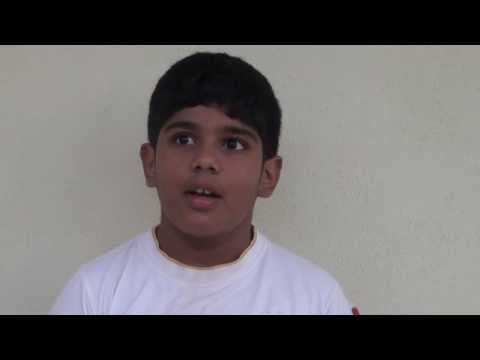

In [ ]:
from IPython.display import YouTubeVideo

# Change the Youtube_ID with the link to your group's video.
YOUTUBE_ID = 'YTKI-nDvKRo'

YouTubeVideo(YOUTUBE_ID)

In [ ]:
!pip install youtube_dl
!youtube-dl -f 'bestvideo[ext=mp4]' --output "youtube.%(ext)s" https://www.youtube.com/watch?v=$YOUTUBE_ID

[youtube] YTKI-nDvKRo: Downloading webpage
[download] Destination: youtube.mp4
[download] 100% of 39.10MiB in 15:22


In [ ]:
# trim video
!ffmpeg -y -loglevel info -i youtube.mp4 -ss 00:00:44 -t 10 /content/youtube_kid.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [ ]:
!mkdir -p /content/youtube_kid_frames/
video_to_frames('/content/youtube_kid.mp4', '/content/youtube_kid_frames/ytkid')

Successfully generated! /content/youtube_kid_frames/ytkid


In [ ]:
!mkdir -p /content/yt_test_data/reference_frames
!mkdir -p /content/yt_test_data/target_frames

# reference frames
!cp /content/youtube_kid_frames/ytkid0024.png /content/yt_test_data/reference_frames
!cp /content/youtube_kid_frames/ytkid0025.png /content/yt_test_data/reference_frames
!cp /content/youtube_kid_frames/ytkid0026.png /content/yt_test_data/reference_frames

# target frames
!cp -r /content/youtube_kid_frames/* /content/yt_test_data/target_frames

In [ ]:
%cd /content/pain_detection_demo
!python test_pspi_au.py --s /content/ytkid.csv -unbc_only -test_data /content/yt_test_data/

/content/pain_detection_demo
  is not a file. Loading model from:  /content/pain_detection_demo/pretrained
Device:  cuda:0


In [ ]:
from IPython.display import HTML
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import pandas as pd

fields = ['AU4', 'AU6', 'AU7', 'AU9', 'AU10', 'AU43']

df = pd.read_csv('/content/ytkid.csv', usecols=fields)

fig, ax = plt.subplots()
ax.set_ylim((0,5))
ax.set_xlabel('AU')
ax.set_ylabel('Intensity')

bar_04 = df['AU4'][0]
bar_06 = df['AU6'][0]
bar_07 = df['AU7'][0]
bar_09 = df['AU9'][0]
bar_10 = df['AU10'][0]
bar_43 = df['AU43'][0]
    
bars = plt.bar(['4', '6', '7', '9', '10', '43'],
               [bar_04, bar_06, bar_07, bar_09, bar_10, bar_43], color='orange')

def animate(i):
    h_04 = df['AU4'][i]
    h_06 = df['AU6'][i]
    h_07 = df['AU7'][i]
    h_09 = df['AU9'][i]
    h_10 = df['AU10'][i]
    h_43 = df['AU43'][i]
    h = [h_04, h_06, h_07, h_09, h_10, h_43]
    
    for j, bar in enumerate(bars):
        bar.set_height(h[j])
    ax.set_title(f'Frame #{i}')

frames = len(df)
ani = FuncAnimation(fig, animate, blit=False, 
                    frames=np.arange(frames),
                    interval=33,
                    save_count=frames,
                    )

# %matplotlib inline
# HTML(ani.to_html5_video())

ani.save('/content/ytkid_au.mp4', writer=animation.FFMpegWriter(fps=30))
plt.close()

In [ ]:
from IPython.display import HTML
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('/content/ytkid.csv', usecols=['PSPI', 'PSPI_from_AU'])
frames = len(df)

fig, ax = plt.subplots()
ax.set_ylim((0,15))
ax.set_xlabel('Frame')
ax.set_ylabel('PSPI')

x = np.arange(frames)
y_pred = df['PSPI']
y_from_au = df['PSPI_from_AU']

plt.xlabel('Frames')
plt.ylabel('PSPI')

line_1, = ax.plot(x, y_from_au, label='PSPI from AUs')
line_2, = ax.plot(x, y_pred, label='PSPI estimated')

def update(i, x, y_from_au, y_pred, line_1, line_2):
    line_1.set_data(x[:i], y_from_au[:i])
    line_1.axes.axis([0, frames, 0, 15])
    line_1.set_label('PSPI from AU')

    line_2.set_data(x[:i], y_pred[:i])
    line_2.axes.axis([0, frames, 0, 15])
    line_2.set_label('PSPI estimated')

    plt.legend(loc='upper right')
    ax.set_title(f'from AUs: {round(y_from_au[i])}, estimated: {round(y_pred[i])}')

    return line_1, line_2,


ani = FuncAnimation(fig, update,
                    fargs=[x, y_from_au, y_pred, line_1, line_2],
                    blit=False, 
                    frames=np.arange(frames),
                    interval=33,
                    save_count=frames,
                    )

# %matplotlib inline
# HTML(ani.to_html5_video())

ani.save('/content/ytkid_pspi.mp4', writer=animation.FFMpegWriter(fps=30))
plt.close()

In [ ]:
# Resize patient video
!ffmpeg -n -i '/content/youtube_kid.mp4' \
    -vf "scale=w=320:h=240:force_original_aspect_ratio=1,pad=320:240:(ow-iw)/2:(oh-ih)/2" \
-c:v libx264 '/content/youtube_kid-resized.mp4' &> /dev/null

# Resize AU histogram video
!ffmpeg -n -i '/content/ytkid_au.mp4' \
    -vf "scale=w=320:h=240:force_original_aspect_ratio=1,pad=320:240:(ow-iw)/2:(oh-ih)/2" \
    -c:v libx264 '/content/ytkid_au-resized.mp4' &> /dev/null

# Resize PSPI histogram video
!ffmpeg -n -i '/content/ytkid_pspi.mp4' \
    -vf "scale=w=320:h=240:force_original_aspect_ratio=1,pad=320:240:(ow-iw)/2:(oh-ih)/2" \
    -c:v libx264 '/content/ytkid_pspi-resized.mp4' &> /dev/null

# hstack patient video (left) & au plot video (right)
!ffmpeg -n -i '/content/youtube_kid-resized.mp4' -i '/content/ytkid_au-resized.mp4' \
     -i '/content/ytkid_pspi-resized.mp4' -filter_complex hstack=3 \
     '/content/ytkid_out.mp4' &> /dev/null

In [ ]:
from google.colab import files
files.download('/content/ytkid_out.mp4')
files.download('/content/ytkid.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>